# Numerical Integration of ODEs

It can be said that physics is essentially integration. From Newton's equations of motion to Schrödinger's equation, physicists are trained to use a panoply of methods and techniques to integrate various kinds of differential equations. In this post we will explore the usage of python to solve initial value problem <a href="https://en.wikipedia.org/wiki/Ordinary_differential_equation" target="_blank">ordinary differential equations (ODEs)</a>.


## The Runge-Kutta Method

Many methods are available for use to solve ODEs numerically, such as the <a href="https://en.wikipedia.org/wiki/Euler_method" target="_blank">Euler method</a> and the <a href="https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods" target="_blank">Runge-Kutta method</a>. In general, higher order Runge-Kutta methods are much more stable than Euler methods, and are considered to be the "industrial standard" for solving ODEs. We will demonstrate the implementation of the 4th order Runge-Kutta method using Python in this post!

For some initial value problem given by 

_ẏ_ = _f_(_t_, _y_), y(t<sub>0</sub>) = y<sub>0</sub>,

the solution for _y_ at _t_ = _n_ + 1, with time step size Δ<i>t</i> is given by

_y_<sub>_n_+1</sub> = _y_<sub>_n_</sub> + Δ<i>t</i>/6(_k_<sub>1</sub> + 2<i>k</i><sub>2</sub> + 2<i>k</i><sub>3</sub> + _k_<sub>4</sub>)

_t_<sub>_n_+1</sub> = _t_<sub>_n_</sub> + Δ<i>t</i>,

where

<i>k</i><sub>1</sub> =  _f_(_t_<sub>_n_</sub>, _y_<sub>_n_</sub>)

<i>k</i><sub>2</sub> = _f_(_t_<sub>_n_</sub> + Δ<i>t</i>/2, _y_<sub>_n_</sub> + Δ<i>t</i><i>k</i><sub>1</sub>/2)

<i>k</i><sub>3</sub> = _f_(_t_<sub>_n_</sub> + Δ<i>t</i>/2, _y_<sub>_n_</sub> + Δ<i>t</i><i>k</i><sub>2</sub>/2)

<i>k</i><sub>4</sub>= _f_(_t_<sub>_n_</sub> + Δ<i>t</i>, _y_<sub>_n_</sub> + Δ<i>t</i><i>k</i><sub>3</sub>)

## The Runge-Kutta Method in Python

We first define the `ode_steps` function which contains the main loop that iterates through all time steps of the integration. `ode_steps` takes 5 arguments: `ydot_fun` is a function where the function to be integrated is defined,  `y0` is an array containing the initial values, `t` is an array containing the time steps to integrate over, `params` is an array containing the parameters to be used in the integration and `step_fun` is the function where the Runge-Kutta method is defined. As `y0` is the solution at `t = 0`, we iterate the for loop from `t = 1` onwards. At each time step from `t = 1`, we call `step_fun` to perform the actual numerical integration and save the result in the output array `Y`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def ode_steps(ydot_fun, y0, t, params, step_fun):
    Y = np.zeros([len(t), len(y0)])  
    Y[0, :] = y0
    for i in range(len(t) - 1):
        Y[i + 1, :] = step_fun(t[i], t[i + 1], Y[i, :], ydot_fun, params)
    return Y

We next define the function `step_fun` which implements the Runge-Kutta equations above. `step_fun` takes 5 arguments: the current time value `t[i]`, the time value at the next step `t[i + 1]`, the current solution value `Y[i, :]`, `ydot_fun` and `params`. The solution value at the next time step `Y[i + 1, :]` is returned. In this post, we will use `step_fun = rk4`, although you can always use another step function such as the Euler method. We now define the function `rk4`. `rk4` takes 5 parameters which follows that of `step_fun` above, and calls `ydot_fun` to calculate the 4 gradients `k1` to `k4`. The solution at the next time step `y1` is essentially the addition of the weighted average of the 4 gradients to the solution at the previous time step `y0`.

In [2]:
def rk4(t0, t1, y0, ydot_fun, params):
    # This function implements the Runge-Kutta equations k1-k4.
    dt = t1 - t0
    k1 = dt * ydot_fun(y0, t0, params)
    k2 = dt * ydot_fun(y0 + 0.5 * k1, t0 + dt * 0.5, params)
    k3 = dt * ydot_fun(y0 + 0.5 * k2, t0 + dt * 0.5, params)
    k4 = dt * ydot_fun(y0 + k3, t0 + dt, params)
    y1 = y0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
    return y1

Now all we need is something to define in `ydot_fun` to solve. There are many ODEs out there, so to make this post a little more unique we will use the relatively unknown <a href="https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/93JB03129" target="_blank">Julian Volcanic Tremor model</a> which describes how fluid flow through a crack buried within a volcano can generate volcanic harmonic tremor. The Julian Volcanic tremor model is a set of 3 coupled nonlinear ODEs that exhibit a wide range of nonlinear behaviour, similar to the Lorenz attractor or the Rössler attractor. The final set of 3 ODEs to be solved are given by:

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/Julian_tremor_model_eq.png?raw=True" alt="drawing" width="333"/>

where _v_ is the fluid flow speed, _t_ is time, _p1_ and _p2_ are the input and output pressures of the crack, _ρ_ is fluid density, _L_ is the crack length, _η_ is the fluid viscosity, _h_ is the crack wall displacement, _h_<sub>0</sub> is the crack wall displacement equilibrium value and _k_, _A_ and _M_ are, the stiffness, damping constant and mass of the crack wall respectively. This set of ODEs to be solved are implemented as follows. Note that the parameters above are input into `ydot_fun` as `params`.

In [3]:
def julian_plot_demo(p1 = 18 * 10**6, x_ax = 1, y_ax = 2):
    x0 = np.array([1, 2, 3]) # initial conditions
    t = np.arange(0, 100, 0.001) # time steps
    k = 600 * 10**6
    M = (3 * 10**5) * 0
    rho = 2500
    eta = 50
    p2 = 0.1 * 10**6
    #p1 = 18 * 10**6
    h0 = 1
    L = 10
    A = 10**7   
    params = np.array([k, M, rho, eta, p2, p1, h0, L, A])

    def ydot_fun(x, t, params):
        k = params[0]
        M = params[1]
        rho = params[2]
        eta = params[3]
        p2 = params[4]
        p1 = params[5]
        h0 = params[6]
        L = params[7]
        A = params[8]
        xdot = np.zeros(len(x))
        effectm = M + rho * L**3 / 12 / x[1]
        damping = A + L**3 / 12 / x[1] * (12 * eta / x[1]**2 - rho / 2 * x[2] / x[1])
        kcoeff = k * (x[1] - h0)
        Lcoeff = L * (p1 + p2) / 2 - L * rho * x[0]**2 / 2
        xdot[0] = (p1-p2)/(rho*L)-(12*eta*x[0])/(rho*x[1]**2)
        xdot[1] = x[2]
        xdot[2] = (Lcoeff-kcoeff-damping*x[2])/effectm
        return xdot

    Y = ode_steps(ydot_fun, x0, t, params, rk4)
    #return Y

    plt.figure(figsize = (7, 7))
    plt.plot(Y[-10000:, x_ax], Y[-10000:, y_ax])
    plt.xlabel("y")
    plt.ylabel("z")
    plt.grid(True)
    plt.show()

Running the function above generates the chaotic solution below.

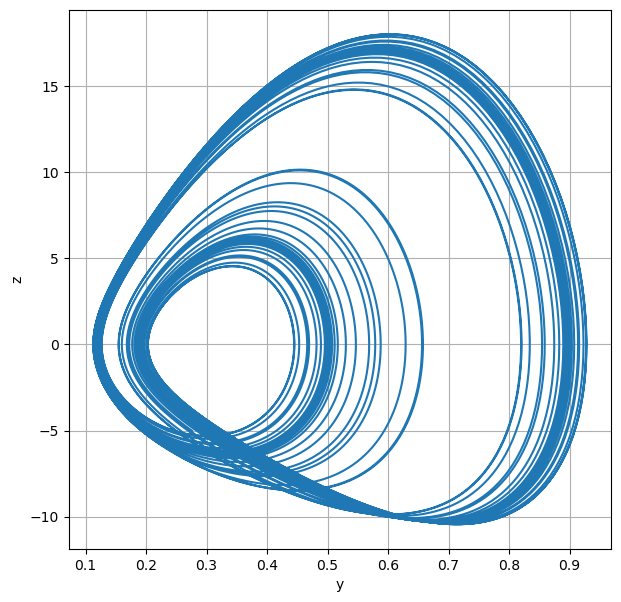

In [4]:
julian_plot_demo()

If we reduce the input pressure to `p1 =  16 * 10 ** 6`, the chaotic behaviour disappears and the trajectory becomes a period 2 limit cycle.

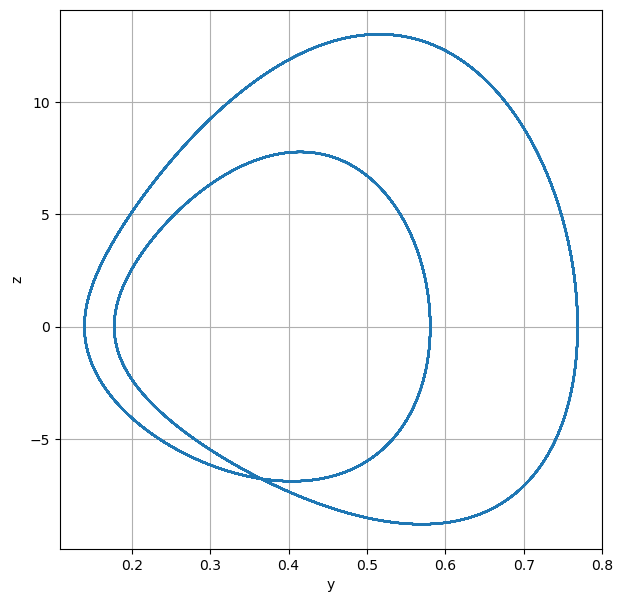

In [5]:
julian_plot_demo(p1 = 16 * 10 ** 6)

Further reducing the input pressure to `p1 = 14 * 10 ** 6` results in the trajectory becoming a period 1 limit cycle. This shows that the Julian Volcanic Tremor model exhibits the period doubling route to chaos. 

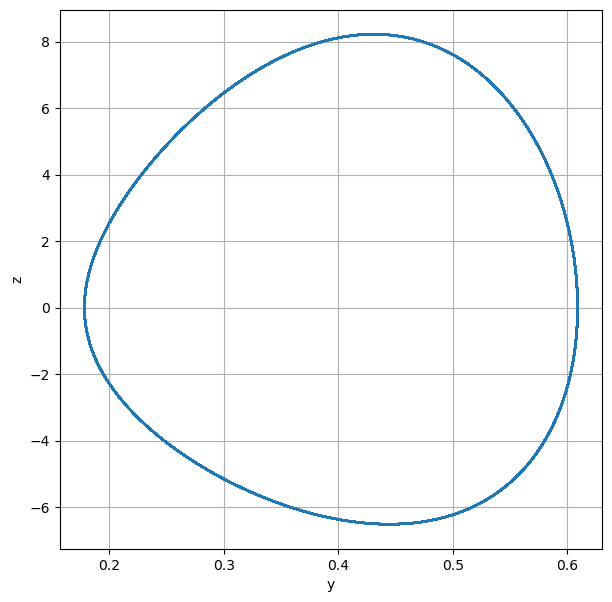

In [6]:
julian_plot_demo(p1 = 14 * 10 ** 6)

This period doubling behaviour was actually observed at Shinmoedake volcano in Japan, and we think that a very similar mechanism is the root cause of the harmonic tremor observed during the 2011 eruption.

As mentioned earlier, `step_fun` can be modified to use other integration methods, and by modifying `ydot_fun` other ODEs can be integrated using the same driver functions, so you can go ahead and try out other systems for yourself!